In [14]:
DF_PATH = 'c:/Users/Ahmed Sadek/ete_project/ml_project/data/processed/preprocessed001_df.pkl'
NA_STRING = 'Not Specified'
TRANSPARENT_STRING = 'rgb(0,0,0,0)'
ROLES_COL =['DevType']
TECH_COLS      = ['LanguageHaveWorkedWith',
                  'DatabaseHaveWorkedWith',
                  'WebframeHaveWorkedWith',
                  'MiscTechHaveWorkedWith',
                  'ToolsTechHaveWorkedWith']
EXPORT_FEATURES_DIR = "../data/processed/"


In [15]:
import pandas as pd 
import numpy as np 
import logging
import pickle
import os 
import yaml 

import plotly
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.cm as cm 
import matplotlib.pyplot as plt

from  sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold  import TSNE 

from sklearn.pipeline  import make_pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split

from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import silhouette_score

pd.options.display.max_rows = 1000

In [16]:
df = pd.read_pickle(DF_PATH)


In [17]:
#one hot encode 
encoded_dfs = {}
for col in ROLES_COL+TECH_COLS:
    binarizer = MultiLabelBinarizer()
    encoded_df = pd.DataFrame(binarizer.fit_transform(df[col]),
                             columns=binarizer.classes_,
                             index=df[col].index)
    encoded_dfs[col] = encoded_df

In [18]:
df_h = pd.concat(encoded_dfs, axis = 1)

In [19]:
df_h

DevType                           \
      Academic researcher Data or business analyst   
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   
...                   ...                      ...   
83434                   0                        0   
83435                   0                        0   
83436                   0                        0   
83437                   0                        0   
83438                   0                        0   

                                                                            \
      Data scientist or machine learning specialist Database administrator   
0                                                 0                      0   
1                                                 0                      0   
2                                                 0                      0   
3                                                 0                      0   
4                                                 0                      0   
...                                             ...                    ...   
83434                                             0                      0   
83435                                             0                      0   
83436                                             1                      0   
83437                                             0                      0   
83438                                             0                      0   

                                                                            \
      Designer DevOps specialist Developer, QA or test Developer, back-end   
0            0                 0                     0                   0   
1            0                 0                     0                   0   
2            0                 0                     0                   0   
3            0                 0                     0                   0   
4            0                 0                     0                   0   
...        ...               ...                   ...                 ...   
83434        0                 0                     0                   1   
83435        0                 0                     0                   0   
83436        0                 1                     0                   0   
83437        0                 0                     0                   1   
83438        0                 0                     0                   1   

                                                     \
      Developer, desktop or enterprise applications   
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 1   
...                                             ...   
83434                                             0   
83435                                             0   
83436                                             0   
83437                                             0   
83438                                             0   

                                                   ...  \
      Developer, embedded applications or devices  ...   
0                                               0  ...   
1                                               0  ...   
2                                               0  ...   
3                                               0  ...   
4                                               0  ...   
...                                           ...  ...   
83434                                           0  ...   
83435                                          

In [20]:
#Dimensionality reduction
skills_h = df_h.drop('DevType', axis= 1).copy()
std_skills = StandardScaler().fit_transform(skills_h)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.



In [21]:
tsne_projection = TSNE(n_components=2,
                      perplexity=3,
                      learning_rate=0.01,
                      init='pca',
                      method='barnes_hut',
                      n_jobs=2,
                      n_iter=10**10,
                      random_state=0).fit_transform(std_skills.T)
tsne_projection = pd.DataFrame(tsne_projection, index = skills_h.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [22]:
tsne_projection.shape

(97, 2)

In [23]:
fig = px.scatter(x= tsne_projection[0], y= tsne_projection[1],text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000,width=1000,title_text='TSNE')
fig.show()

In [25]:
rng_n_cluster = list(range(10,25))
silhoutte_score  = []
best_cluster_model = None 

for n_clster in rng_n_cluster:
    cluster_model = AgglomerativeClustering(n_clusters=n_clster,linkage='ward')
    cluster_label = cluster_model.fit_predict(tsne_projection)
    
    silhouette_avg = silhouette_score(tsne_projection,cluster_label)
    silhoutte_score += [silhouette_avg]
    
    if silhoutte_avg >= np.max(silhoutte_score):
        best_cluster_model = cluster_model
    

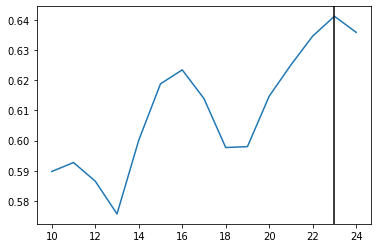

In [27]:
plt.plot(rng_n_cluster,silhoutte_score)
plt.axvline(best_cluster_model.n_clusters,color= 'black')

In [28]:
cluster_labels = ["skills_group_"+str(label)
                 for label in best_cluster_model.labels_]

In [29]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=cluster_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Cluster')
fig.show()

In [30]:
# How to better write this
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(cluster_labels).apply(list)
for cluster, skills in skills_clusters.items():
    print(cluster)
    print(skills)

skills_group_0
['PHP', 'SQL', 'MariaDB', 'MySQL', 'SQLite', 'Drupal', 'Laravel', 'Symfony', 'Vue.js']
skills_group_1
['Bash/Shell', 'Go', 'Perl', 'Rust']
skills_group_10
['Clojure', 'Haskell', 'LISP']
skills_group_11
['DynamoDB', 'Ansible', 'Flow', 'Pulumi', 'Terraform']
skills_group_12
['Node.js', 'MongoDB', 'Express', 'Gatsby', 'React.js', 'React Native', 'Yarn']
skills_group_13
['Ruby', 'Ruby on Rails']
skills_group_14
['Svelte', 'Deno']
skills_group_15
['APL', 'COBOL', 'Crystal', 'Delphi', 'IBM DB2']
skills_group_16
['HTML/CSS', 'JavaScript', 'jQuery']
skills_group_17
['Unity 3D', 'Unreal Engine']
skills_group_18
['Dart', 'Firebase', 'Flutter']
skills_group_19
['Objective-C', 'Swift']
skills_group_2
['C#', 'F#', 'PowerShell', 'VBA', 'Microsoft SQL Server', 'ASP.NET', 'ASP.NET Core ', '.NET Core / .NET 5', '.NET Framework', 'Xamarin']
skills_group_20
['TypeScript', 'Angular', 'Angular.js', 'Cordova']
skills_group_21
['Chef', 'Puppet']
skills_group_22
['Elixir', 'Erlang']
skills_grou

In [31]:
new_features = []

for cluster, skills in skills_clusters.items():
    cluster_sum = skills_h.droplevel(0, axis=1)[skills].sum(axis=1)
    cluster_sum.name = cluster
    new_features.append(cluster_sum)

fe_clustered_skills = pd.concat(new_features, axis=1)
fe_clustered_skills

,skills_group_0,skills_group_1,skills_group_10,skills_group_11,skills_group_12,skills_group_13,skills_group_14,skills_group_15,skills_group_16,skills_group_17,...,skills_group_20,skills_group_21,skills_group_22,skills_group_3,skills_group_4,skills_group_5,skills_group_6,skills_group_7,skills_group_8,skills_group_9
0,4,0,0,0,0,0,0,0,2,0,...,0,0,0,1,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,2,0,0,3,0,0,0,0,0,2
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,3,0,2,2
3,0,0,0,0,0,0,0,0,2,0,...,2,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,1,0,...,0,0,0,6,0,2,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,2,0,1,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,2,0,0
83435,4,0,0,0,1,1,0,0,1,2,...,0,0,0,3,1,0,0,0,0,1
83436,0,0,0,3,1,0,0,0,0,0,...,0,0,0,5,0,1,2,2,1,3
83437,0,1,0,2,4,0,0,0,1,0,...,0,0,0,5,0,1,2,0,2,3


In [32]:
combined_feature = pd.concat([fe_clustered_skills,skills_h.droplevel(0,axis=1)],axis=1)
roles_df=df_h['DevType'].copy()
X_train, X_test,Y_train, Y_test= train_test_split(combined_feature,roles_df,test_size=0.3,random_state=0)

# #compute samples weightto deal with classes imbalanced 


In [36]:
#assign class weight as inverse of its frequancy 
class_weights = (1/roles_df.sum(axis=0))
#multiply class weight with one hot encoded values and get mean for each sample 
sample_weight = np.multiply(class_weights.values,Y_train.values).sum(axis=1)

In [42]:
def f1_from_confusion_matrix(confusion_matrix):
    return (confusion_matrix[1,1] / (confusion_matrix[1,1]+(0.5 * (confusion_matrix[0,1] + confusion_matrix[1,0]))))
feature_sets = {'original': skills_h.droplevel(0,axis=1).columns.tolist(), 
                'clusters': fe_clustered_skills.columns.tolist()}

In [43]:
results = {}

for feature_set_name, feature_set in feature_sets.items():
    # Create sub trainings
    sub_train = X_train[feature_set].copy()
    sub_test  = X_test[feature_set].copy()
    
    # Train classifier 
    clf = MultiOutputClassifier(LogisticRegression())
    clf.fit(sub_train, Y_train, sample_weight=sample_weight)

    # Calcaulte F1 for training data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_train, clf.predict(sub_train))
    f1_train_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Calcaulte F1 for testing data
    multilabel_confusion_matricies = multilabel_confusion_matrix(Y_test, clf.predict(sub_test))
    f1_test_scores = [f1_from_confusion_matrix(matrix) 
                       for matrix in multilabel_confusion_matricies]

    # Add to results
    set_result = pd.DataFrame({"train": f1_train_scores, "test":f1_test_scores}, 
                              index=roles_df.columns.to_list())
    results[feature_set_name] = set_result.sort_values('test')
    
    
    # Print
    print("Feature set: " + feature_set_name)
    print(".. Mean train F1:", np.mean(f1_train_scores))    
    print(".. Mean test F1:", np.mean(f1_test_scores))
    print()

Feature set: original
.. Mean train F1: 0.10894397378773973
.. Mean test F1: 0.1082290894138183

Feature set: clusters
.. Mean train F1: 0.14471717682034196
.. Mean test F1: 0.14524911593104625



In [44]:
#Export new features 

features_path = os.path.join(EXPORT_FEATURES_DIR,"features_skills_clusters.pkl")
fe_clustered_skills.to_pickle(features_path)

In [45]:
description_path = os.path.join(EXPORT_FEATURES_DIR, "features_skills_clusters_description.yaml")
with open(description_path, 'w') as outfile:
    yaml.dump(skills_clusters.to_dict(), outfile)